In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import scipy.io as sio
from matplotlib import rc

def set_style_sns():
    sns.set_context('paper')
    sns.set(font = 'serif')
    sns.set(font_scale = 1.3)
    
    sns.set_style('white', {
        'font.family': 'serif',
        'font.serif': ['Time', 'Palatino', 'serif'],
        'lines.markersize': 10
    })
    
    
plt.rcParams.update({'font.size':16})
set_style_sns()

plt.rcParams.update({'text.usetex': False})

In [2]:
data = sio.matlab.loadmat('../data/FlatBeam_NLResponse_RandVibe.mat')['out']
y = data[0]['def'][0].T[:, :, np.newaxis][:,10,:]
u = data[0]['fext'][0].T[:, :, np.newaxis][:,10,:]
t = data[0]['t'][0][0]

print(y.shape, u.shape, t.shape)

(10001, 1) (10001, 1) (10001,)


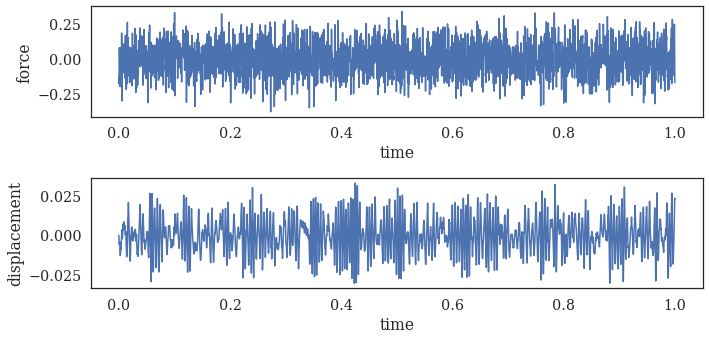

In [3]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t,u)
plt.xlabel('time')
plt.ylabel('force')

plt.subplot(2,1,2)
plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('displacement')

plt.tight_layout()
plt.show()

5000


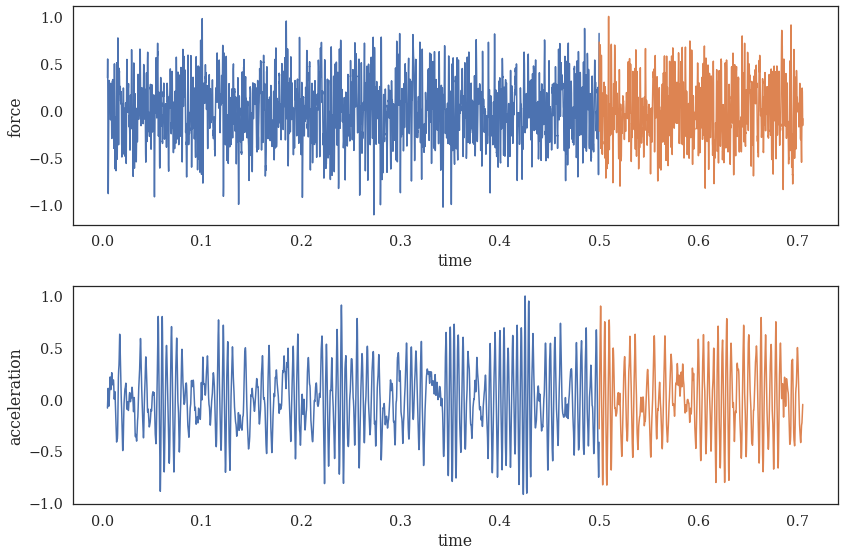

In [4]:
umax = np.max(u)
ymax = np.max(y)

u_norm = u/umax
y_norm = y/ymax

N = len(u)
ntrain = int(N*0.5)
start = 50

print(ntrain)
utrain = u_norm[start:ntrain]
ytrain = y_norm[start:ntrain]
ttrain = t[start:ntrain]
intrain = np.hstack([utrain,ytrain])

utest = u_norm[ntrain:start+ntrain+2000]
ytest = y_norm[ntrain:start+ntrain+2000]
ttest = t[ntrain:start+ntrain+2000]
intest = np.hstack([utest,ytest])

ufull = np.concatenate([utrain, utest], axis = 0)
yfull = np.concatenate([ytrain, ytest], axis = 0)
infull = np.concatenate([intrain, intest], axis = 0)

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(ttrain,utrain)
plt.plot(ttest,utest)
plt.xlabel('time')
plt.ylabel('force')

plt.subplot(2,1,2)
plt.plot(ttrain,ytrain)
plt.plot(ttest,ytest)
plt.xlabel('time')
plt.ylabel('acceleration')

plt.tight_layout()
plt.show()

In [5]:
def create_inout_sequences(input_data, output_data, tw):
    xs = []
    ys = []

    for i in range(len(input_data)-tw-1):
        xy = input_data[i:(i+tw), 1]
        xu = input_data[i+1:(i+tw)+1, 0]
        x = np.vstack([xu,xy])
        y = output_data[i+tw]

        xs.append(x)
        ys.append(y)

    return np.transpose(np.array(xs),[0,1,2]), np.array(ys)

In [9]:
train_window = 12

x_train, y_train = create_inout_sequences(intrain, ytrain, train_window)
x_val, y_val = create_inout_sequences(intest, ytest, train_window)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

print(x_train.shape, y_train.shape)

x_full, y_full = create_inout_sequences(infull, yfull, train_window)

x_full = torch.from_numpy(x_full).float()
y_full = torch.from_numpy(y_full).float()

print(x_full.shape, y_full.shape)

torch.Size([4937, 2, 12]) torch.Size([4937, 1])
torch.Size([6987, 2, 12]) torch.Size([6987, 1])


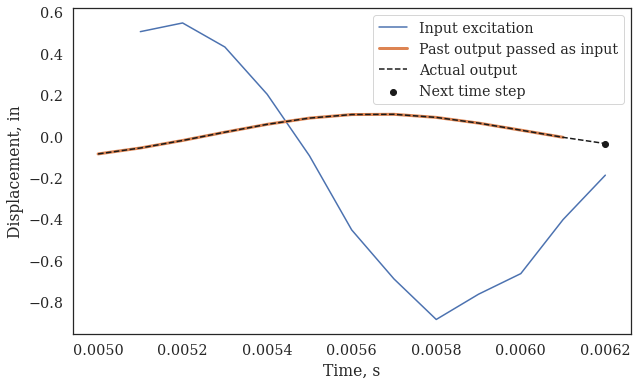

In [11]:
plt.figure(figsize=(10,6))
plt.plot(ttrain[1:train_window+1], x_train[0,0,:])
plt.plot(ttrain[:train_window], x_train[0,1,:], linewidth = 3)
plt.scatter(ttrain[train_window], y_train[0], color = 'k')
plt.plot(ttrain[:train_window + 1], ytrain[:train_window + 1], 'k--')
plt.legend(['Input excitation', 'Past output passed as input', 
           'Actual output', 'Next time step'], loc = 'best')
plt.xlabel('Time, s')
plt.ylabel('Displacement, in')
plt.savefig('./../images/input_output_12tw.tiff')
plt.show()


In [12]:
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [13]:
import torch.nn.functional as F


class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, seq_len, dropout):
        super(TCN, self).__init__()
        self.seq_len = seq_len
        self.num_channels = num_channels
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1]*seq_len, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        # x needs to have dimension (N, C, L) in order to be passed into CNN
        output = self.tcn(x).transpose(1, 2).reshape((-1, self.seq_len*self.num_channels[-1]))
        output = self.linear(output).double()
        return output

In [17]:
model = TCN(input_size = 2, 
            output_size = 1, 
            num_channels = [6]*4, 
            kernel_size = 3, 
            seq_len = train_window, 
            dropout = 0.1)

In [18]:
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss(reduction = "sum")

def train(model,epoch, X_train, Y_train, batch_size):
    global lr
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:, :, :], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size), :, :], Y_train[i:(i+batch_size)]
        optimizer.zero_grad()
        output = model(x)

        loss = F.mse_loss(output, y.double())

        loss.backward()

        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % 25 == 0:
            cur_loss = total_loss / 25
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0


def evaluate(model, X_test, Y_test):
    #model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.mse_loss(output, Y_test)
        print('\nTest set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return test_loss.item()

In [19]:
epochs = 50000
batch_size = 250

for ep in range(1, epochs+1):
    train(model, ep, x_train, y_train, batch_size)
    print('Epoch: {}'.format(ep))
    tloss = evaluate(model, x_val, y_val)


Epoch: 1

Test set: Average loss: 0.250830

Epoch: 2

Test set: Average loss: 0.196407

Epoch: 3

Test set: Average loss: 0.163627

Epoch: 4

Test set: Average loss: 0.141993

Epoch: 5

Test set: Average loss: 0.132840

Epoch: 6

Test set: Average loss: 0.127593

Epoch: 7

Test set: Average loss: 0.125140

Epoch: 8

Test set: Average loss: 0.123875

Epoch: 9

Test set: Average loss: 0.121356

Epoch: 10

Test set: Average loss: 0.120401

Epoch: 11

Test set: Average loss: 0.118325

Epoch: 12

Test set: Average loss: 0.116624

Epoch: 13

Test set: Average loss: 0.115776

Epoch: 14

Test set: Average loss: 0.114876

Epoch: 15

Test set: Average loss: 0.112256

Epoch: 16

Test set: Average loss: 0.110935

Epoch: 17

Test set: Average loss: 0.109089

Epoch: 18

Test set: Average loss: 0.107224

Epoch: 19

Test set: Average loss: 0.107111

Epoch: 20

Test set: Average loss: 0.104023

Epoch: 21

Test set: Average loss: 0.102122

Epoch: 22

Test set: Average loss: 0.100955

Epoch: 23

Test set

Epoch: 182

Test set: Average loss: 0.007885

Epoch: 183

Test set: Average loss: 0.007790

Epoch: 184

Test set: Average loss: 0.007727

Epoch: 185

Test set: Average loss: 0.007474

Epoch: 186

Test set: Average loss: 0.007610

Epoch: 187

Test set: Average loss: 0.007376

Epoch: 188

Test set: Average loss: 0.007380

Epoch: 189

Test set: Average loss: 0.007743

Epoch: 190

Test set: Average loss: 0.007943

Epoch: 191

Test set: Average loss: 0.007693

Epoch: 192

Test set: Average loss: 0.007294

Epoch: 193

Test set: Average loss: 0.007381

Epoch: 194

Test set: Average loss: 0.007374

Epoch: 195

Test set: Average loss: 0.007139

Epoch: 196

Test set: Average loss: 0.007328

Epoch: 197

Test set: Average loss: 0.006825

Epoch: 198

Test set: Average loss: 0.007102

Epoch: 199

Test set: Average loss: 0.006812

Epoch: 200

Test set: Average loss: 0.007018

Epoch: 201

Test set: Average loss: 0.006973

Epoch: 202

Test set: Average loss: 0.006514

Epoch: 203

Test set: Average loss


Test set: Average loss: 0.001912

Epoch: 361

Test set: Average loss: 0.001747

Epoch: 362

Test set: Average loss: 0.001888

Epoch: 363

Test set: Average loss: 0.001852

Epoch: 364

Test set: Average loss: 0.001881

Epoch: 365

Test set: Average loss: 0.001866

Epoch: 366

Test set: Average loss: 0.001802

Epoch: 367

Test set: Average loss: 0.001762

Epoch: 368

Test set: Average loss: 0.001881

Epoch: 369

Test set: Average loss: 0.001770

Epoch: 370

Test set: Average loss: 0.001731

Epoch: 371

Test set: Average loss: 0.001810

Epoch: 372

Test set: Average loss: 0.001773

Epoch: 373

Test set: Average loss: 0.001742

Epoch: 374

Test set: Average loss: 0.001708

Epoch: 375

Test set: Average loss: 0.001680

Epoch: 376

Test set: Average loss: 0.001696

Epoch: 377

Test set: Average loss: 0.001673

Epoch: 378

Test set: Average loss: 0.001684

Epoch: 379

Test set: Average loss: 0.001606

Epoch: 380

Test set: Average loss: 0.001654

Epoch: 381

Test set: Average loss: 0.001671


Epoch: 539

Test set: Average loss: 0.000758

Epoch: 540

Test set: Average loss: 0.000715

Epoch: 541

Test set: Average loss: 0.000733

Epoch: 542

Test set: Average loss: 0.000713

Epoch: 543

Test set: Average loss: 0.000703

Epoch: 544

Test set: Average loss: 0.000698

Epoch: 545

Test set: Average loss: 0.000673

Epoch: 546

Test set: Average loss: 0.000698

Epoch: 547

Test set: Average loss: 0.000688

Epoch: 548

Test set: Average loss: 0.000698

Epoch: 549

Test set: Average loss: 0.000697

Epoch: 550

Test set: Average loss: 0.000726

Epoch: 551

Test set: Average loss: 0.000674

Epoch: 552

Test set: Average loss: 0.000686

Epoch: 553

Test set: Average loss: 0.000708

Epoch: 554

Test set: Average loss: 0.000663

Epoch: 555

Test set: Average loss: 0.000696

Epoch: 556

Test set: Average loss: 0.000680

Epoch: 557

Test set: Average loss: 0.000651

Epoch: 558

Test set: Average loss: 0.000642

Epoch: 559

Test set: Average loss: 0.000655

Epoch: 560

Test set: Average loss


Test set: Average loss: 0.000354

Epoch: 718

Test set: Average loss: 0.000360

Epoch: 719

Test set: Average loss: 0.000357

Epoch: 720

Test set: Average loss: 0.000350

Epoch: 721

Test set: Average loss: 0.000361

Epoch: 722

Test set: Average loss: 0.000345

Epoch: 723

Test set: Average loss: 0.000370

Epoch: 724

Test set: Average loss: 0.000364

Epoch: 725

Test set: Average loss: 0.000345

Epoch: 726

Test set: Average loss: 0.000356

Epoch: 727

Test set: Average loss: 0.000351

Epoch: 728

Test set: Average loss: 0.000354

Epoch: 729

Test set: Average loss: 0.000343

Epoch: 730

Test set: Average loss: 0.000346

Epoch: 731

Test set: Average loss: 0.000359

Epoch: 732

Test set: Average loss: 0.000362

Epoch: 733

Test set: Average loss: 0.000337

Epoch: 734

Test set: Average loss: 0.000356

Epoch: 735

Test set: Average loss: 0.000342

Epoch: 736

Test set: Average loss: 0.000341

Epoch: 737

Test set: Average loss: 0.000336

Epoch: 738

Test set: Average loss: 0.000332


Epoch: 896

Test set: Average loss: 0.000185

Epoch: 897

Test set: Average loss: 0.000193

Epoch: 898

Test set: Average loss: 0.000196

Epoch: 899

Test set: Average loss: 0.000187

Epoch: 900

Test set: Average loss: 0.000193

Epoch: 901

Test set: Average loss: 0.000204

Epoch: 902

Test set: Average loss: 0.000200

Epoch: 903

Test set: Average loss: 0.000190

Epoch: 904

Test set: Average loss: 0.000198

Epoch: 905

Test set: Average loss: 0.000182

Epoch: 906

Test set: Average loss: 0.000197

Epoch: 907

Test set: Average loss: 0.000191

Epoch: 908

Test set: Average loss: 0.000188

Epoch: 909

Test set: Average loss: 0.000191

Epoch: 910

Test set: Average loss: 0.000181

Epoch: 911

Test set: Average loss: 0.000184

Epoch: 912

Test set: Average loss: 0.000178

Epoch: 913

Test set: Average loss: 0.000178

Epoch: 914

Test set: Average loss: 0.000189

Epoch: 915

Test set: Average loss: 0.000183

Epoch: 916

Test set: Average loss: 0.000180

Epoch: 917

Test set: Average loss

Epoch: 1073

Test set: Average loss: 0.000116

Epoch: 1074

Test set: Average loss: 0.000125

Epoch: 1075

Test set: Average loss: 0.000122

Epoch: 1076

Test set: Average loss: 0.000126

Epoch: 1077

Test set: Average loss: 0.000126

Epoch: 1078

Test set: Average loss: 0.000119

Epoch: 1079

Test set: Average loss: 0.000121

Epoch: 1080

Test set: Average loss: 0.000121

Epoch: 1081

Test set: Average loss: 0.000119

Epoch: 1082

Test set: Average loss: 0.000116

Epoch: 1083

Test set: Average loss: 0.000123

Epoch: 1084

Test set: Average loss: 0.000113

Epoch: 1085

Test set: Average loss: 0.000113

Epoch: 1086

Test set: Average loss: 0.000120

Epoch: 1087

Test set: Average loss: 0.000116

Epoch: 1088

Test set: Average loss: 0.000113

Epoch: 1089

Test set: Average loss: 0.000121

Epoch: 1090

Test set: Average loss: 0.000113

Epoch: 1091

Test set: Average loss: 0.000113

Epoch: 1092

Test set: Average loss: 0.000114

Epoch: 1093

Test set: Average loss: 0.000116

Epoch: 1094



Epoch: 1248

Test set: Average loss: 0.000082

Epoch: 1249

Test set: Average loss: 0.000087

Epoch: 1250

Test set: Average loss: 0.000087

Epoch: 1251

Test set: Average loss: 0.000082

Epoch: 1252

Test set: Average loss: 0.000087

Epoch: 1253

Test set: Average loss: 0.000088

Epoch: 1254

Test set: Average loss: 0.000085

Epoch: 1255

Test set: Average loss: 0.000083

Epoch: 1256

Test set: Average loss: 0.000085

Epoch: 1257

Test set: Average loss: 0.000093

Epoch: 1258

Test set: Average loss: 0.000080

Epoch: 1259

Test set: Average loss: 0.000087

Epoch: 1260

Test set: Average loss: 0.000079

Epoch: 1261

Test set: Average loss: 0.000088

Epoch: 1262

Test set: Average loss: 0.000082

Epoch: 1263

Test set: Average loss: 0.000085

Epoch: 1264

Test set: Average loss: 0.000083

Epoch: 1265

Test set: Average loss: 0.000083

Epoch: 1266

Test set: Average loss: 0.000083

Epoch: 1267

Test set: Average loss: 0.000085

Epoch: 1268

Test set: Average loss: 0.000084

Epoch: 1269



Epoch: 1423

Test set: Average loss: 0.000062

Epoch: 1424

Test set: Average loss: 0.000060

Epoch: 1425

Test set: Average loss: 0.000066

Epoch: 1426

Test set: Average loss: 0.000067

Epoch: 1427

Test set: Average loss: 0.000065

Epoch: 1428

Test set: Average loss: 0.000064

Epoch: 1429

Test set: Average loss: 0.000067

Epoch: 1430

Test set: Average loss: 0.000065

Epoch: 1431

Test set: Average loss: 0.000062

Epoch: 1432

Test set: Average loss: 0.000063

Epoch: 1433

Test set: Average loss: 0.000065

Epoch: 1434

Test set: Average loss: 0.000064

Epoch: 1435

Test set: Average loss: 0.000064

Epoch: 1436

Test set: Average loss: 0.000063

Epoch: 1437

Test set: Average loss: 0.000062

Epoch: 1438

Test set: Average loss: 0.000068

Epoch: 1439

Test set: Average loss: 0.000063

Epoch: 1440

Test set: Average loss: 0.000065

Epoch: 1441

Test set: Average loss: 0.000062

Epoch: 1442

Test set: Average loss: 0.000065

Epoch: 1443

Test set: Average loss: 0.000064

Epoch: 1444



Epoch: 1598

Test set: Average loss: 0.000052

Epoch: 1599

Test set: Average loss: 0.000050

Epoch: 1600

Test set: Average loss: 0.000053

Epoch: 1601

Test set: Average loss: 0.000054

Epoch: 1602

Test set: Average loss: 0.000050

Epoch: 1603

Test set: Average loss: 0.000054

Epoch: 1604

Test set: Average loss: 0.000051

Epoch: 1605

Test set: Average loss: 0.000054

Epoch: 1606

Test set: Average loss: 0.000054

Epoch: 1607

Test set: Average loss: 0.000054

Epoch: 1608

Test set: Average loss: 0.000049

Epoch: 1609

Test set: Average loss: 0.000051

Epoch: 1610

Test set: Average loss: 0.000054

Epoch: 1611

Test set: Average loss: 0.000049

Epoch: 1612

Test set: Average loss: 0.000052

Epoch: 1613

Test set: Average loss: 0.000049

Epoch: 1614

Test set: Average loss: 0.000051

Epoch: 1615

Test set: Average loss: 0.000054

Epoch: 1616

Test set: Average loss: 0.000050

Epoch: 1617

Test set: Average loss: 0.000049

Epoch: 1618

Test set: Average loss: 0.000050

Epoch: 1619



Epoch: 1773

Test set: Average loss: 0.000044

Epoch: 1774

Test set: Average loss: 0.000045

Epoch: 1775

Test set: Average loss: 0.000043

Epoch: 1776

Test set: Average loss: 0.000043

Epoch: 1777

Test set: Average loss: 0.000045

Epoch: 1778

Test set: Average loss: 0.000045

Epoch: 1779

Test set: Average loss: 0.000043

Epoch: 1780

Test set: Average loss: 0.000043

Epoch: 1781

Test set: Average loss: 0.000043

Epoch: 1782

Test set: Average loss: 0.000044

Epoch: 1783

Test set: Average loss: 0.000043

Epoch: 1784

Test set: Average loss: 0.000044

Epoch: 1785

Test set: Average loss: 0.000043

Epoch: 1786

Test set: Average loss: 0.000044

Epoch: 1787

Test set: Average loss: 0.000042

Epoch: 1788

Test set: Average loss: 0.000045

Epoch: 1789

Test set: Average loss: 0.000041

Epoch: 1790

Test set: Average loss: 0.000045

Epoch: 1791

Test set: Average loss: 0.000043

Epoch: 1792

Test set: Average loss: 0.000041

Epoch: 1793

Test set: Average loss: 0.000043

Epoch: 1794



Epoch: 1948

Test set: Average loss: 0.000039

Epoch: 1949

Test set: Average loss: 0.000039

Epoch: 1950

Test set: Average loss: 0.000037

Epoch: 1951

Test set: Average loss: 0.000038

Epoch: 1952

Test set: Average loss: 0.000037

Epoch: 1953

Test set: Average loss: 0.000039

Epoch: 1954

Test set: Average loss: 0.000037

Epoch: 1955

Test set: Average loss: 0.000039

Epoch: 1956

Test set: Average loss: 0.000038

Epoch: 1957

Test set: Average loss: 0.000037

Epoch: 1958

Test set: Average loss: 0.000038

Epoch: 1959

Test set: Average loss: 0.000037

Epoch: 1960

Test set: Average loss: 0.000039

Epoch: 1961

Test set: Average loss: 0.000037

Epoch: 1962

Test set: Average loss: 0.000038

Epoch: 1963

Test set: Average loss: 0.000037

Epoch: 1964

Test set: Average loss: 0.000038

Epoch: 1965

Test set: Average loss: 0.000037

Epoch: 1966

Test set: Average loss: 0.000040

Epoch: 1967

Test set: Average loss: 0.000037

Epoch: 1968

Test set: Average loss: 0.000037

Epoch: 1969



Epoch: 2123

Test set: Average loss: 0.000033

Epoch: 2124

Test set: Average loss: 0.000034

Epoch: 2125

Test set: Average loss: 0.000033

Epoch: 2126

Test set: Average loss: 0.000035

Epoch: 2127

Test set: Average loss: 0.000034

Epoch: 2128

Test set: Average loss: 0.000035

Epoch: 2129

Test set: Average loss: 0.000037

Epoch: 2130

Test set: Average loss: 0.000035

Epoch: 2131

Test set: Average loss: 0.000033

Epoch: 2132

Test set: Average loss: 0.000032

Epoch: 2133

Test set: Average loss: 0.000035

Epoch: 2134

Test set: Average loss: 0.000034

Epoch: 2135

Test set: Average loss: 0.000034

Epoch: 2136

Test set: Average loss: 0.000034

Epoch: 2137

Test set: Average loss: 0.000035

Epoch: 2138

Test set: Average loss: 0.000035

Epoch: 2139

Test set: Average loss: 0.000034

Epoch: 2140

Test set: Average loss: 0.000033

Epoch: 2141

Test set: Average loss: 0.000032

Epoch: 2142

Test set: Average loss: 0.000034

Epoch: 2143

Test set: Average loss: 0.000033

Epoch: 2144



Epoch: 2298

Test set: Average loss: 0.000030

Epoch: 2299

Test set: Average loss: 0.000029

Epoch: 2300

Test set: Average loss: 0.000031

Epoch: 2301

Test set: Average loss: 0.000031

Epoch: 2302

Test set: Average loss: 0.000031

Epoch: 2303

Test set: Average loss: 0.000030

Epoch: 2304

Test set: Average loss: 0.000030

Epoch: 2305

Test set: Average loss: 0.000030

Epoch: 2306

Test set: Average loss: 0.000029

Epoch: 2307

Test set: Average loss: 0.000029

Epoch: 2308

Test set: Average loss: 0.000031

Epoch: 2309

Test set: Average loss: 0.000029

Epoch: 2310

Test set: Average loss: 0.000031

Epoch: 2311

Test set: Average loss: 0.000028

Epoch: 2312

Test set: Average loss: 0.000030

Epoch: 2313

Test set: Average loss: 0.000029

Epoch: 2314

Test set: Average loss: 0.000031

Epoch: 2315

Test set: Average loss: 0.000029

Epoch: 2316

Test set: Average loss: 0.000032

Epoch: 2317

Test set: Average loss: 0.000031

Epoch: 2318

Test set: Average loss: 0.000029

Epoch: 2319



Epoch: 2473

Test set: Average loss: 0.000027

Epoch: 2474

Test set: Average loss: 0.000026

Epoch: 2475

Test set: Average loss: 0.000027

Epoch: 2476

Test set: Average loss: 0.000028

Epoch: 2477

Test set: Average loss: 0.000028

Epoch: 2478

Test set: Average loss: 0.000028

Epoch: 2479

Test set: Average loss: 0.000027

Epoch: 2480

Test set: Average loss: 0.000028

Epoch: 2481

Test set: Average loss: 0.000029

Epoch: 2482

Test set: Average loss: 0.000027

Epoch: 2483

Test set: Average loss: 0.000028

Epoch: 2484

Test set: Average loss: 0.000029

Epoch: 2485

Test set: Average loss: 0.000027

Epoch: 2486

Test set: Average loss: 0.000028

Epoch: 2487

Test set: Average loss: 0.000027

Epoch: 2488

Test set: Average loss: 0.000028

Epoch: 2489

Test set: Average loss: 0.000027

Epoch: 2490

Test set: Average loss: 0.000027

Epoch: 2491

Test set: Average loss: 0.000030

Epoch: 2492

Test set: Average loss: 0.000028

Epoch: 2493

Test set: Average loss: 0.000025

Epoch: 2494



Epoch: 2648

Test set: Average loss: 0.000026

Epoch: 2649

Test set: Average loss: 0.000026

Epoch: 2650

Test set: Average loss: 0.000024

Epoch: 2651

Test set: Average loss: 0.000025

Epoch: 2652

Test set: Average loss: 0.000026

Epoch: 2653

Test set: Average loss: 0.000026

Epoch: 2654

Test set: Average loss: 0.000025

Epoch: 2655

Test set: Average loss: 0.000025

Epoch: 2656

Test set: Average loss: 0.000026

Epoch: 2657

Test set: Average loss: 0.000027

Epoch: 2658

Test set: Average loss: 0.000026

Epoch: 2659

Test set: Average loss: 0.000024

Epoch: 2660

Test set: Average loss: 0.000024

Epoch: 2661

Test set: Average loss: 0.000024

Epoch: 2662

Test set: Average loss: 0.000025

Epoch: 2663

Test set: Average loss: 0.000026

Epoch: 2664

Test set: Average loss: 0.000025

Epoch: 2665

Test set: Average loss: 0.000026

Epoch: 2666

Test set: Average loss: 0.000025

Epoch: 2667

Test set: Average loss: 0.000025

Epoch: 2668

Test set: Average loss: 0.000027

Epoch: 2669



Epoch: 2823

Test set: Average loss: 0.000024

Epoch: 2824

Test set: Average loss: 0.000025

Epoch: 2825

Test set: Average loss: 0.000024

Epoch: 2826

Test set: Average loss: 0.000024

Epoch: 2827

Test set: Average loss: 0.000023

Epoch: 2828

Test set: Average loss: 0.000024

Epoch: 2829

Test set: Average loss: 0.000023

Epoch: 2830

Test set: Average loss: 0.000023

Epoch: 2831

Test set: Average loss: 0.000024

Epoch: 2832

Test set: Average loss: 0.000023

Epoch: 2833

Test set: Average loss: 0.000025

Epoch: 2834

Test set: Average loss: 0.000022

Epoch: 2835

Test set: Average loss: 0.000024

Epoch: 2836

Test set: Average loss: 0.000022

Epoch: 2837

Test set: Average loss: 0.000023

Epoch: 2838

Test set: Average loss: 0.000024

Epoch: 2839

Test set: Average loss: 0.000024

Epoch: 2840

Test set: Average loss: 0.000024

Epoch: 2841

Test set: Average loss: 0.000024

Epoch: 2842

Test set: Average loss: 0.000024

Epoch: 2843

Test set: Average loss: 0.000024

Epoch: 2844



Epoch: 2998

Test set: Average loss: 0.000021

Epoch: 2999

Test set: Average loss: 0.000021

Epoch: 3000

Test set: Average loss: 0.000022

Epoch: 3001

Test set: Average loss: 0.000021

Epoch: 3002

Test set: Average loss: 0.000021

Epoch: 3003

Test set: Average loss: 0.000023

Epoch: 3004

Test set: Average loss: 0.000022

Epoch: 3005

Test set: Average loss: 0.000021

Epoch: 3006

Test set: Average loss: 0.000022

Epoch: 3007

Test set: Average loss: 0.000021

Epoch: 3008

Test set: Average loss: 0.000023

Epoch: 3009

Test set: Average loss: 0.000022

Epoch: 3010

Test set: Average loss: 0.000022

Epoch: 3011

Test set: Average loss: 0.000022

Epoch: 3012

Test set: Average loss: 0.000023

Epoch: 3013

Test set: Average loss: 0.000021

Epoch: 3014

Test set: Average loss: 0.000022

Epoch: 3015

Test set: Average loss: 0.000022

Epoch: 3016

Test set: Average loss: 0.000023

Epoch: 3017

Test set: Average loss: 0.000021

Epoch: 3018

Test set: Average loss: 0.000021

Epoch: 3019



Epoch: 3173

Test set: Average loss: 0.000021

Epoch: 3174

Test set: Average loss: 0.000020

Epoch: 3175

Test set: Average loss: 0.000019

Epoch: 3176

Test set: Average loss: 0.000021

Epoch: 3177

Test set: Average loss: 0.000021

Epoch: 3178

Test set: Average loss: 0.000021

Epoch: 3179

Test set: Average loss: 0.000020

Epoch: 3180

Test set: Average loss: 0.000020

Epoch: 3181

Test set: Average loss: 0.000020

Epoch: 3182

Test set: Average loss: 0.000022

Epoch: 3183

Test set: Average loss: 0.000018

Epoch: 3184

Test set: Average loss: 0.000020

Epoch: 3185

Test set: Average loss: 0.000022

Epoch: 3186

Test set: Average loss: 0.000020

Epoch: 3187

Test set: Average loss: 0.000020

Epoch: 3188

Test set: Average loss: 0.000022

Epoch: 3189

Test set: Average loss: 0.000021

Epoch: 3190

Test set: Average loss: 0.000021

Epoch: 3191

Test set: Average loss: 0.000022

Epoch: 3192

Test set: Average loss: 0.000021

Epoch: 3193

Test set: Average loss: 0.000021

Epoch: 3194



Epoch: 3348

Test set: Average loss: 0.000020

Epoch: 3349

Test set: Average loss: 0.000018

Epoch: 3350

Test set: Average loss: 0.000019

Epoch: 3351

Test set: Average loss: 0.000019

Epoch: 3352

Test set: Average loss: 0.000020

Epoch: 3353

Test set: Average loss: 0.000019

Epoch: 3354

Test set: Average loss: 0.000020

Epoch: 3355

Test set: Average loss: 0.000020

Epoch: 3356

Test set: Average loss: 0.000020

Epoch: 3357

Test set: Average loss: 0.000020

Epoch: 3358

Test set: Average loss: 0.000020

Epoch: 3359

Test set: Average loss: 0.000019

Epoch: 3360

Test set: Average loss: 0.000020

Epoch: 3361

Test set: Average loss: 0.000021

Epoch: 3362

Test set: Average loss: 0.000020

Epoch: 3363

Test set: Average loss: 0.000020

Epoch: 3364

Test set: Average loss: 0.000020

Epoch: 3365

Test set: Average loss: 0.000019

Epoch: 3366

Test set: Average loss: 0.000020

Epoch: 3367

Test set: Average loss: 0.000020

Epoch: 3368

Test set: Average loss: 0.000018

Epoch: 3369



Epoch: 3523

Test set: Average loss: 0.000018

Epoch: 3524

Test set: Average loss: 0.000018

Epoch: 3525

Test set: Average loss: 0.000019

Epoch: 3526

Test set: Average loss: 0.000018

Epoch: 3527

Test set: Average loss: 0.000019

Epoch: 3528

Test set: Average loss: 0.000020

Epoch: 3529

Test set: Average loss: 0.000019

Epoch: 3530

Test set: Average loss: 0.000021

Epoch: 3531

Test set: Average loss: 0.000019

Epoch: 3532

Test set: Average loss: 0.000018

Epoch: 3533

Test set: Average loss: 0.000021

Epoch: 3534

Test set: Average loss: 0.000018

Epoch: 3535

Test set: Average loss: 0.000019

Epoch: 3536

Test set: Average loss: 0.000018

Epoch: 3537

Test set: Average loss: 0.000018

Epoch: 3538

Test set: Average loss: 0.000018

Epoch: 3539

Test set: Average loss: 0.000019

Epoch: 3540

Test set: Average loss: 0.000018

Epoch: 3541

Test set: Average loss: 0.000018

Epoch: 3542

Test set: Average loss: 0.000020

Epoch: 3543

Test set: Average loss: 0.000018

Epoch: 3544



Epoch: 3698

Test set: Average loss: 0.000018

Epoch: 3699

Test set: Average loss: 0.000019

Epoch: 3700

Test set: Average loss: 0.000017

Epoch: 3701

Test set: Average loss: 0.000018

Epoch: 3702

Test set: Average loss: 0.000017

Epoch: 3703

Test set: Average loss: 0.000016

Epoch: 3704

Test set: Average loss: 0.000018

Epoch: 3705

Test set: Average loss: 0.000018

Epoch: 3706

Test set: Average loss: 0.000018

Epoch: 3707

Test set: Average loss: 0.000019

Epoch: 3708

Test set: Average loss: 0.000017

Epoch: 3709

Test set: Average loss: 0.000017

Epoch: 3710

Test set: Average loss: 0.000017

Epoch: 3711

Test set: Average loss: 0.000018

Epoch: 3712

Test set: Average loss: 0.000018

Epoch: 3713

Test set: Average loss: 0.000018

Epoch: 3714

Test set: Average loss: 0.000017

Epoch: 3715

Test set: Average loss: 0.000018

Epoch: 3716

Test set: Average loss: 0.000018

Epoch: 3717

Test set: Average loss: 0.000016

Epoch: 3718

Test set: Average loss: 0.000017

Epoch: 3719



KeyboardInterrupt: 

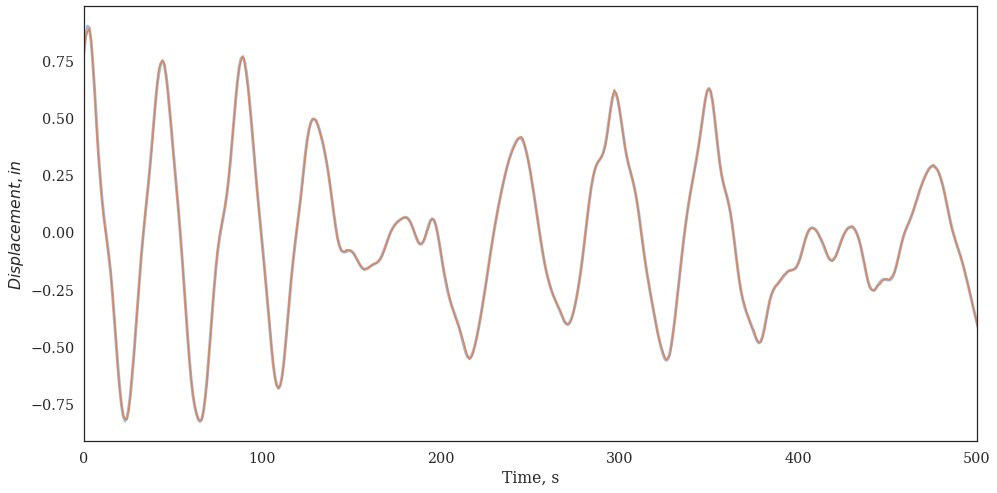

In [20]:
ypred = model(x_val)

plt.figure(figsize = (16, 8))

plt.plot(y_val, linewidth = 3, alpha = 0.5)
plt.plot(ypred.detach().numpy())

plt.ylabel('$Displacement, in$')
plt.xlabel('Time, s')

plt.xlim([0,500])
plt.show()

In [21]:

def simulate(x0, u, future):
    tw = x0.shape[-1]
    feats = x0.shape[0]

    x_ = x0.reshape((1,feats,tw))
    x = x0
    ypred = model(x_)
    
    for ii in range(1,future):
        new_pair = np.array([u[tw + ii][0], ypred.detach().numpy()[0][0]]).reshape((2,-1))
        x = np.concatenate([x, new_pair], axis = -1)
        
        x_ = x[:, -tw:].reshape((1, feats, tw))
        x_ = torch.from_numpy(x_)
        ypred = model(x_.float())
        
    return x

In [22]:
x0 = x_val[0]
ypred_sim = simulate(x0, utest, 500)
ypred_sim = ypred_sim[-1,train_window:]

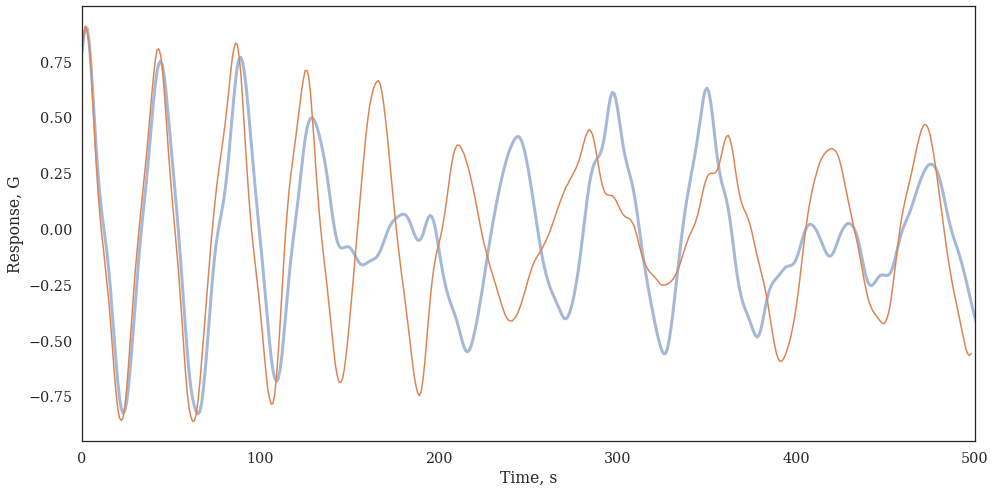

In [23]:

plt.figure(figsize = (16, 8))

plt.plot(y_val, linewidth = 3, alpha = 0.5)
plt.plot(ypred_sim.T)

plt.ylabel('Response, G')
plt.xlabel('Time, s')

plt.xlim([0,500])
plt.show()

In [24]:
utest.shape
u_norm.shape

(10001, 1)

In [25]:
x0 = x_full[0]
npred = x_full.shape[0] - 1
ypred_sim = simulate(x0, ufull, npred)
ypred_sim = ypred_sim[-1,train_window:]


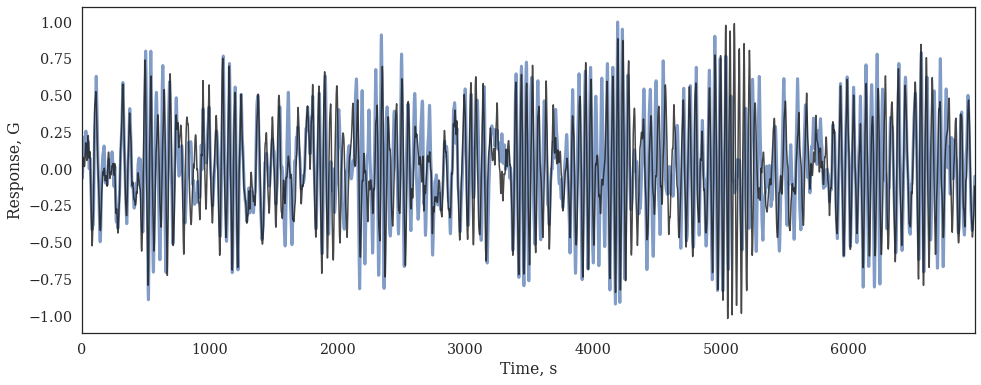

In [26]:
plt.figure(figsize = (16, 6))

plt.plot(yfull[train_window:], linewidth = 3, alpha = 0.7)
plt.plot(ypred_sim.T, 'k', alpha = 0.8)

plt.ylabel('Response, G')
plt.xlabel('Time, s')

plt.xlim([0,npred])
plt.show()

In [27]:
np.save(open('yfull_baseline.npy', 'wb'), ypred_sim)

In [123]:
import pickle
y_physics = np.load(open('yfull_physics_tw12.npy', 'rb'))
y_arx = np.load(open('yfull_arx.npy', 'rb'))

In [62]:
print(y_physics.shape, y_arx.shape)

(3, 6973) (7000, 1)


In [120]:
from scipy.stats import pearsonr

def calc_mse(x1, x2):
    return np.mean((x1.reshape((-1,))-x2.reshape((-1,)))**2)

def calc_pearsonr(x1,x2):
    return pearsonr(x1.reshape((-1,)), x2.reshape((-1,)))
    

In [125]:
start = 0
nplot = len(yfull) - 100

mse_base = calc_mse(yfull[start + 24:start + 24 + nplot], ypred_sim[start+12:start+12+nplot])
mse_physics = calc_mse(yfull[start + 24:start + 24 + nplot], y_physics[0,12+start:12+start+nplot])
mse_arx = calc_mse(yfull[start + 24:start + 24 + nplot], y_arx[start+24:start+24+nplot])

print(mse_base, mse_physics, mse_arx)

0.07960846470430703 0.07984270136955429 0.09582361374994777


In [126]:
start = 0
nplot = len(yfull) - 100

r_base = calc_pearsonr(yfull[start + 24:start + 24 + nplot], ypred_sim[start+12:start+12+nplot])
r_physics = calc_pearsonr(yfull[start + 24:start + 24 + nplot], y_physics[0,12+start:12+start+nplot])
r_arx = calc_pearsonr(yfull[start + 24:start + 24 + nplot], y_arx[start+24:start+24+nplot])

print(r_base, r_physics, r_arx)

(0.6384967162489513, 0.0) (0.6300745497131481, 0.0) (0.5120452343142261, 0.0)


(50, 1000)

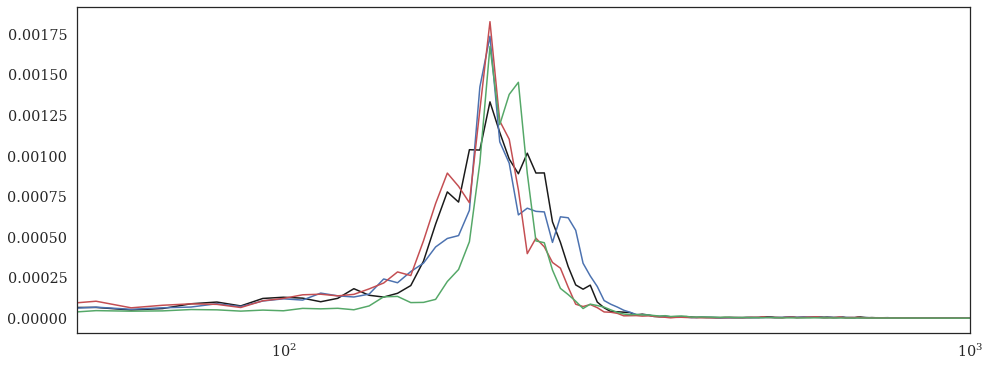

In [158]:
from scipy.signal import welch, stft

start = 0
nplot = len(yfull) - 100

dt = t[1] - t[0]
fs = 1/dt # sampling frequency

yfull_psd = yfull[start + 24:start + 24 + nplot]
ybase_psd = ypred_sim[start+12:start+12+nplot]
yphysics_psd = y_physics[0,12+start:12+start+nplot]
yarx_psd = y_arx[start+24:start+24+nplot]

nperseg = 1500

freq, psd_full = welch(yfull_psd.T, fs, nperseg = nperseg, noverlap = np.ceil(nperseg*0.7))
freq, psd_base = welch(ybase_psd.T, fs, nperseg = nperseg, noverlap = np.ceil(nperseg*0.7))
freq, psd_physics = welch(yphysics_psd.T, fs, nperseg = nperseg, noverlap = np.ceil(nperseg*0.7))
freq, psd_arx = welch(yarx_psd.T, fs, nperseg = nperseg, noverlap = np.ceil(nperseg*0.7))


plt.figure(figsize = (16, 6))
plt.semilogx(freq, psd_full.reshape((-1,)), 'k')
plt.semilogx(freq, psd_base.reshape((-1,)), 'b')
plt.semilogx(freq, psd_physics.reshape((-1,)), 'r')
plt.semilogx(freq, psd_arx.reshape((-1,)), 'g')

plt.xlim([50, 1000])

(1, 751, 17)


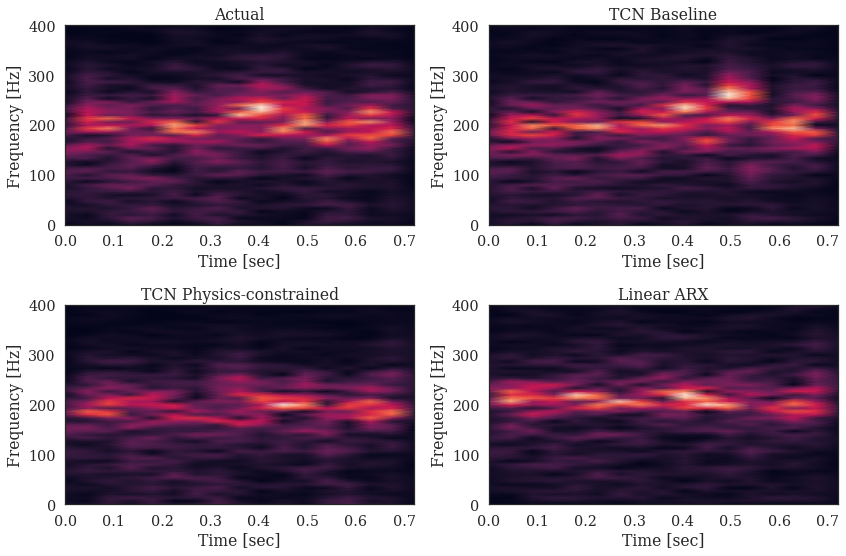

In [184]:
nperseg = 1500

freq, tvec, stft_full = stft(yfull_psd.T, fs, nperseg = nperseg, noverlap = np.ceil(nperseg*0.7))
freq, tvec, stft_base = stft(ybase_psd.T, fs, nperseg = nperseg, noverlap = np.ceil(nperseg*0.7))
freq, tvec, stft_physics = stft(yphysics_psd.T, fs, nperseg = nperseg, noverlap = np.ceil(nperseg*0.7))
freq, tvec, stft_arx = stft(yarx_psd.T, fs, nperseg = nperseg, noverlap = np.ceil(nperseg*0.7))

print(stft_full.shape)

plt.figure(figsize = (12, 8))

plt.subplot(2,2,1)
plt.pcolormesh(tvec, freq, np.abs(stft_full[0]), shading='gouraud')
plt.ylim([0,400])

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Actual')

plt.subplot(2,2,2)
plt.pcolormesh(tvec, freq, np.abs(stft_base), shading='gouraud')
plt.ylim([0,400])

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('TCN Baseline')

plt.subplot(2,2,3)
plt.pcolormesh(tvec, freq, np.abs(stft_physics), shading='gouraud')
plt.ylim([0,400])

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('TCN Physics-constrained')

plt.subplot(2,2,4)
plt.pcolormesh(tvec, freq, np.abs(stft_arx[0]), shading='gouraud')
plt.ylim([0,400])

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Linear ARX')

plt.tight_layout()

plt.savefig('comparison_stft.tiff')
plt.show()
#plt.xlim([50, 1000])

In [ ]:
np.abs(stft_arx[0])

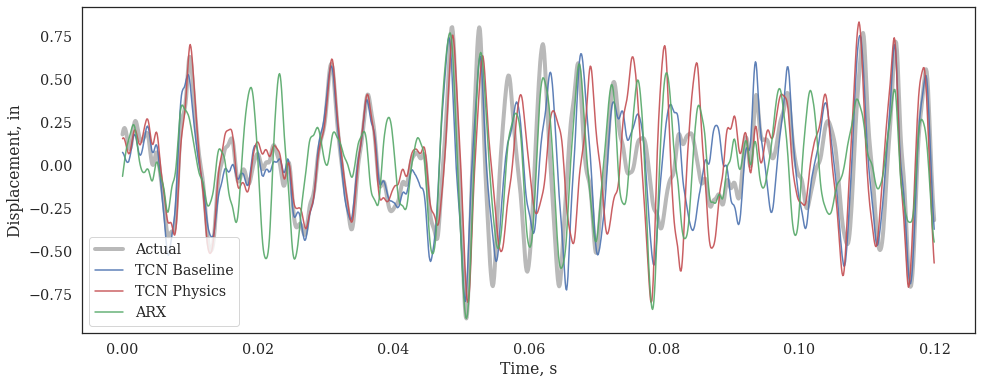

In [181]:
plt.figure(figsize = (16, 6))

start = 0
nplot = 1200

plt.plot(t[start:start+nplot],yfull[start + 24:start + 24 + nplot], 'k', linewidth = 4, alpha = 0.3)
plt.plot(t[start:start+nplot],ypred_sim[start+12:start+12+nplot].T, 'b', alpha = 0.9)
plt.plot(t[start:start+nplot],y_physics[0,start+12:start+12+nplot].T, 'r', alpha = 0.9)
plt.plot(t[start:start+nplot],y_arx[start+24:start+24+nplot], 'g', alpha = 0.9)

plt.legend(['Actual', 'TCN Baseline', 'TCN Physics', 'ARX'])

plt.ylabel('Displacement, in')
plt.xlabel('Time, s')

plt.savefig('comparison_start.tiff')

plt.show()

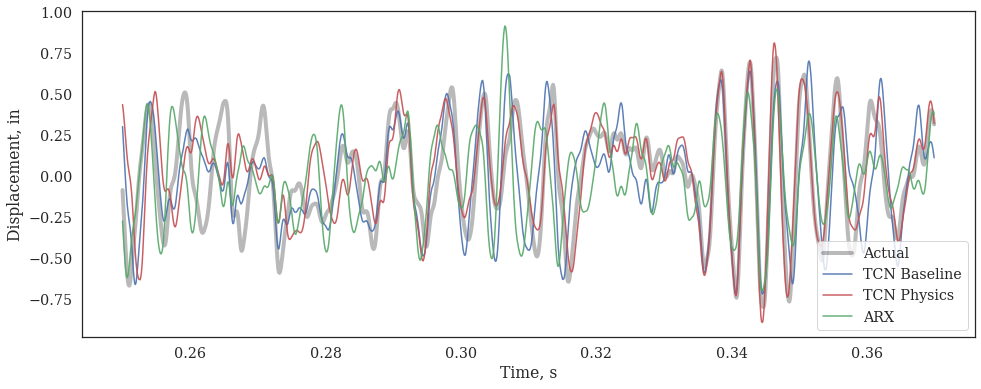

In [182]:
plt.figure(figsize = (16, 6))

start = 2500
nplot = 1200

plt.plot(t[start:start+nplot],yfull[start + 24:start + 24 + nplot], 'k', linewidth = 4, alpha = 0.3)
plt.plot(t[start:start+nplot],ypred_sim[start+12:start+12+nplot].T, 'b', alpha = 0.9)
plt.plot(t[start:start+nplot],y_physics[0,start+12:start+12+nplot].T, 'r', alpha = 0.9)
plt.plot(t[start:start+nplot],y_arx[start+24:start+24+nplot], 'g', alpha = 0.9)

plt.legend(['Actual', 'TCN Baseline', 'TCN Physics', 'ARX'], loc = 'lower right')

plt.ylabel('Displacement, in')
plt.xlabel('Time, s')

plt.savefig('comparison_end.tiff')

plt.show()

In [104]:
nchannels = [3, 6, 9]
nlayers = [3, 5, 7]
kernelsize = [3]

epochs = 500
batch_size = 250

hyperparams = []

for nc in nchannels:
    for nl in nlayers:
        for ks in kernelsize:
            model = TCN(input_size = 2, 
                        output_size = 1, 
                        num_channels = [nc]*nl, 
                        kernel_size = ks, 
                        seq_len = train_window, 
                        dropout = 0.1)
            print([nc]*nl)
            for ep in range(1, epochs+1):
                train(model, ep, x_train, y_train, batch_size)
                if ep % 50 == 0:
                    print('Epoch: {}'.format(ep))
                    tloss = evaluate(model, x_val, y_val)
            
            hyperparams.append([nc, nl, ks, tloss])
            print(hyperparams[-1])
            
pickle.dump(hyperparams, open('hyperparam_runs.pickle', 'wb'))


[3, 3, 3]
Epoch: 50

Test set: Average loss: 1.173970

Epoch: 100

Test set: Average loss: 1.164860

Epoch: 150

Test set: Average loss: 1.174647

Epoch: 200

Test set: Average loss: 1.169710

Epoch: 250

Test set: Average loss: 1.175539

Epoch: 300

Test set: Average loss: 1.177534

Epoch: 350

Test set: Average loss: 1.175668

Epoch: 400

Test set: Average loss: 1.165821

Epoch: 450

Test set: Average loss: 1.174930

Epoch: 500

Test set: Average loss: 1.190137

[3, 3, 3, 1.1901369514374631]
[3, 3, 3, 3, 3]
Epoch: 50

Test set: Average loss: 0.244408

Epoch: 100

Test set: Average loss: 0.248154

Epoch: 150

Test set: Average loss: 0.246772

Epoch: 200

Test set: Average loss: 0.248602

Epoch: 250

Test set: Average loss: 0.248202

Epoch: 300

Test set: Average loss: 0.240986

Epoch: 350

Test set: Average loss: 0.247317

Epoch: 400

Test set: Average loss: 0.244650

Epoch: 450

Test set: Average loss: 0.244559

Epoch: 500

Test set: Average loss: 0.245608

[3, 5, 3, 0.24560780395239

NameError: name 'pickle' is not defined

In [105]:
import pickle 
pickle.dump(hyperparams, open('hyperparam_runs.pickle', 'wb'))

In [106]:
hyperparams

[[3, 3, 3, 1.1901369514374631],
 [3, 5, 3, 0.2456078039523973],
 [3, 7, 3, 0.5105965993993377],
 [6, 3, 3, 0.11973414125472952],
 [6, 5, 3, 0.5458264064765384],
 [6, 7, 3, 0.20835276448076956],
 [9, 3, 3, 0.14021653580262358],
 [9, 5, 3, 0.27441562471524916],
 [9, 7, 3, 0.13629748571598935]]

In [109]:
from statsmodels.tsa.arima_model import ARMA

ModuleNotFoundError: No module named 'statsmodels'